In [90]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import tqdm as tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [91]:
ticker = "AAPL"
stock = yf.Ticker("AAPL")
startDate = "2022-01-01"
endDate = dt.datetime.now()
fundamental = stock.financials
techanalysis = yf.download(ticker, startDate, endDate)

[*********************100%***********************]  1 of 1 completed


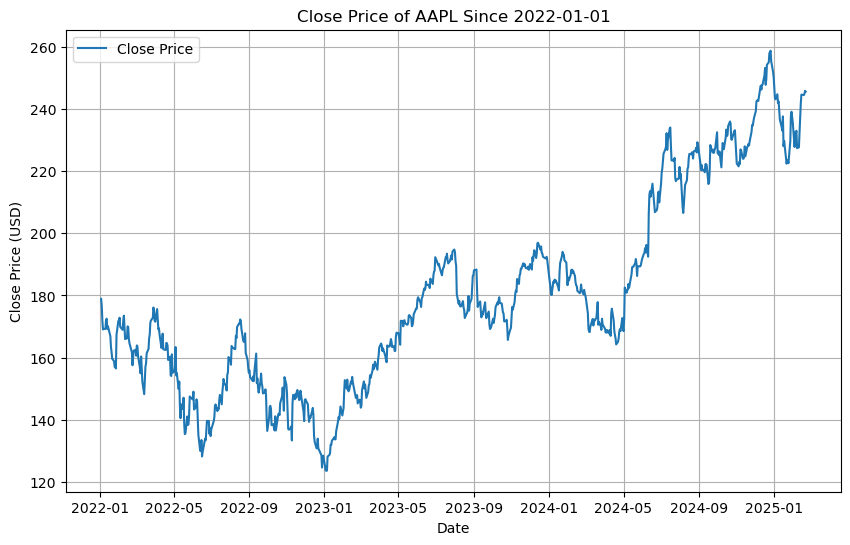

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(techanalysis['Close'], label='Close Price')
plt.title(f'Close Price of {ticker} Since {startDate}')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#Technical Analysis Calculations
# 1. Fast Stochastic Oscilator ((Current Close - Lowest Low over N periods)/(Highest High over N periods - Lowest Low over N periods)*100)
RSIdata = techanalysis.tail(40)

In [94]:
LowestLow = RSIdata ['Low'].min()
LL = LowestLow.iloc[0]
HighestHigh = RSIdata ['High'].max()
HH = HighestHigh.iloc[0]
CurrentClose = RSIdata.tail(1) ['Close']
CC = CurrentClose.values[0]
FRSI = ((CC-LL)/(HH-LL))*100
FRSI = FRSI.astype(int)

if FRSI <= 20:
    FRSIrating = 5
elif 21 <= FRSI <= 40:
    FRSIrating = 4
elif 41 <= FRSI <= 60:
    FRSIrating = 3
elif 61 <= FRSI <= 80:
    FRSIrating = 2
else:
    FRSIrating = 1
FRSIrating
#Strong Buy - 0-20 (5)
#Buy - 21-40 (4)
#Neutral - 41-60 (3)
#Sell - 61-80 (2)
#Strong Sell - 81-100 (1)

2

In [95]:
# 2. Slow Stochastic Oscillator (Simple Moving Average of FRSI over m periods)
SMA1 = RSIdata ['Close'].sum()/40
SMA = SMA1.values[0]
smoothing_period = 3
SRSI = SMA/smoothing_period
SRSI = SRSI.astype(int)

if SRSI <= 20:
    SRSIrating = 5
elif 21 <= SRSI <= 40:
    SRSIrating = 4
elif 41 <= SRSI <= 60:
    SRSIrating = 3
elif 61 <= SRSI <= 80:
    SRSIrating = 2
else:
    SRSIrating = 1
SRSIrating

#Strong Buy - 0-20 (5)
#Buy - 21-40 (4)
#Neutral - 41-60 (3)
#Sell - 61-80 (2)
#Strong Sell - 81-100 (1)

2

In [96]:
# 3. Williams %R ((Highest High - Close)/(Highest High - Lowest Low)*-100)
WR = (HH-CC)/(HH-LL)*-100
WR = WR.astype(int)

if -100 <= WR <= -80:
    WRrating = 5
elif -79 <= WR <= -60:
    WRrating = 4
elif -59 <= WR <= -40:
    WRrating = 3
elif -39 <= WR <= -20:
    WRrating = 2
else:
    WRrating = 1
WRrating

#Strong Buy - (-100)-(-80) (5)
#Buy - (-79)-(-60) (4)
#Neutral - (-59)-(-40) (3)
#Sell - (-39)-(-20) (2)
#Strong Sell - (-19)-0 (1)

2

In [97]:
#Each Technical Analysis Factor has a weight of approx. 33.333333%
techscore = (1/3*FRSIrating)+(1/3*SRSIrating)+(1/3*WRrating)
techscore

2.0

In [98]:
#Monte Carlo Simulation of Asset Market Performance for Upcoming 252d
mcdata = yf.download(ticker, startDate, endDate) ['Close']

[*********************100%***********************]  1 of 1 completed


In [99]:
returns = np.log(mcdata/mcdata.shift(1))
returns = returns.dropna()
volatility = returns.std().values[0]
volatility

0.017073907176532545

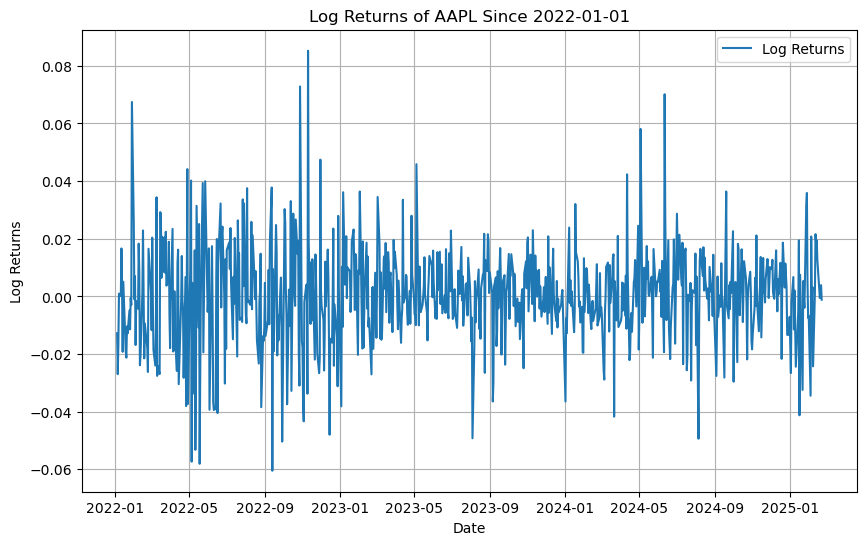

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Log Returns')
plt.title(f'Log Returns of {ticker} Since {startDate}')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
#Monte Carlo Simulation Parameters
simulations = 10000
days = 252
last_price = mcdata.tail(1).values[0]

In [102]:
def run_monteCarlo(simulations, days, last_price, returns):
    
    # Initialize a list to store all simulation results
    simulations_list = []
    
    for x in tqdm.tqdm(range(simulations)):
        price_series = [last_price]
        
        for y in range(1, days):
            price = price_series[-1] * (1 + np.random.normal(np.mean(returns), volatility))
            price_series.append(price)
        
        simulations_list.append(price_series)
    
    # Convert the list of simulations into a DataFrame all at once
    simulation_df = pd.DataFrame(simulations_list).transpose()
    
    return simulation_df

In [103]:
simulation_df = run_monteCarlo(simulations, days, last_price, returns)

100%|████████████████████████████████████| 10000/10000 [00:30<00:00, 324.15it/s]


In [104]:
row = simulation_df.tail(1)
row1 = np.concatenate(row.values)
mean_value = row1.mean()
MCresult = (mean_value/last_price)-1
# Print the results
print("The expected price in 252 trading days is: ",mean_value," according to the result of Monte Carlo Simulation")

The expected price in 252 trading days is:  [270.68560901]  according to the result of Monte Carlo Simulation


In [105]:
if 0.096 <= MCresult <= 999999999999999999999999:
    MCrating = 5
elif 0.076 <= MCresult <= 0.095:
    MCrating = 4
elif 0.046 <= MCresult <= 0.075:
    MCrating = 3
elif 0.02 <= MCresult <= 0.045:
    MCrating = 2
else:
    MCrating = 1
MCrating
MCscore = MCrating
MCscore
#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)

5

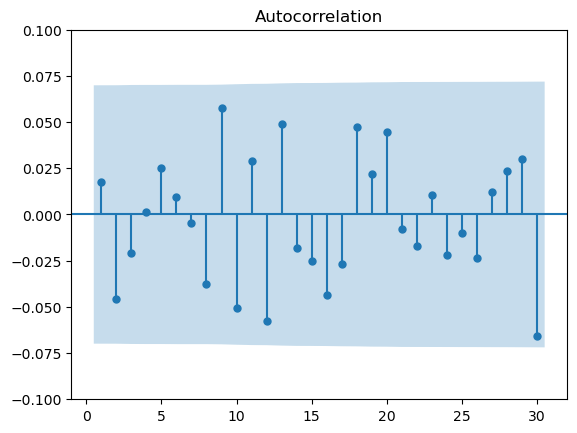

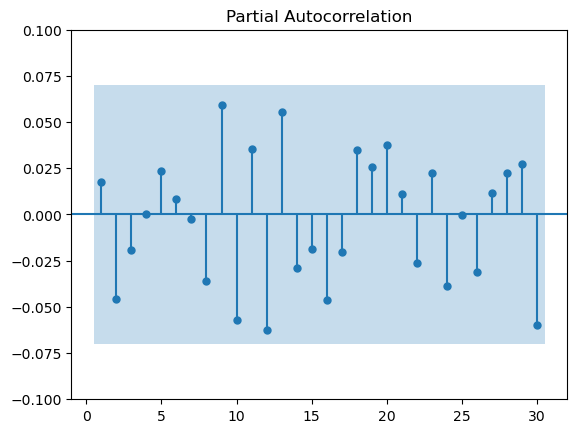

In [106]:
#ARIMA Model Simulation
plot_acf(returns, lags=30, zero = False)
plt.ylim(-0.1, 0.1)
plt.show()
plot_pacf(returns, lags=30, zero = False)
plt.ylim(-0.1, 0.1)
plt.show()

In [107]:
result = adfuller(returns)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    returns = returns.diff().dropna()

ADF Statistic: -20.57582058986346
p-value: 0.0


In [108]:
model = auto_arima(returns, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4160.824, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4166.351, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4164.612, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4164.617, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4162.570, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4164.790, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.309 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  786
Model:                        SARIMAX   Log Likelihood                2084.176
Date:                Sun, 23 Feb 2025   AIC                          -4166.351
Time:                        16:47:14   BIC                          -4161.684
Sample:                             0   HQIC                         -4164.557
    

In [109]:
model_fit = ARIMA(returns, order=model.order).fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/var/folders/68/wtl2nd4s0j3fvb1d1nt0qxvh0000gn/T/ipykernel_30038/1733110168.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulated_prices = last_price[0] * np.exp(np.cumsum(simulated_returns, axis=1))


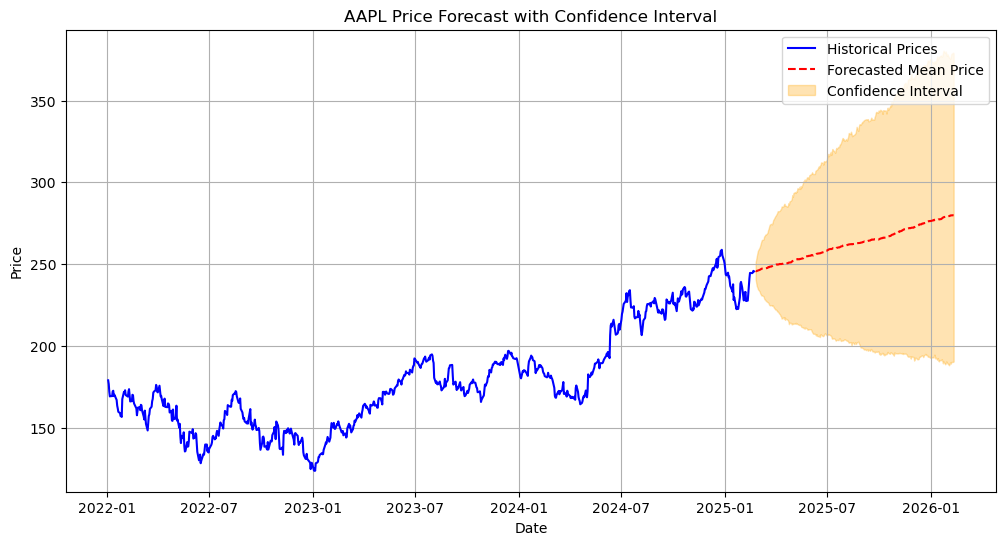

In [110]:
n_simulations = 1000 
forecast_steps = 252  
simulated_returns = np.zeros((n_simulations, forecast_steps))

for i in range(n_simulations):
    simulated_returns[i, :] = model_fit.simulate(nsimulations=forecast_steps)


last_price = mcdata.iloc[-1]
simulated_prices = last_price[0] * np.exp(np.cumsum(simulated_returns, axis=1))


mean_prices = np.mean(simulated_prices, axis=0)
lower_bound = np.percentile(simulated_prices, 10, axis=0)
upper_bound = np.percentile(simulated_prices, 90, axis=0)


future_dates = pd.date_range(start=mcdata.index[-1], periods=forecast_steps + 1, freq='B')[1:]

plt.figure(figsize=(12, 6))
plt.plot(mcdata.index, mcdata, label='Historical Prices', color='blue')
plt.plot(future_dates, mean_prices, label='Forecasted Mean Price', color='red', linestyle='--')
plt.fill_between(future_dates, lower_bound, upper_bound, color='orange', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title(f'{ticker} Price Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [111]:
ARIMA_stock_price = mean_prices[-1]
ARIMA_end_price = ARIMA_stock_price
ARIMAresult = (ARIMA_end_price/last_price)-1
ARIMAresult = round(ARIMAresult.values[0],2)
ARIMAresult

0.14

In [112]:
ARIMA_stock_price = mean_prices[-1]
ARIMA_end_price = ARIMA_stock_price
ARIMAresult = (ARIMA_end_price/last_price)-1
ARIMAresult = round(ARIMAresult.values[0],2)

if 0.096 <= ARIMAresult <= 999999999999999999999999:
    ARIMArating = 5
elif 0.076 <= ARIMAresult <= 0.095:
    ARIMArating = 4
elif 0.046 <= ARIMAresult <= 0.075:
    ARIMArating = 3
elif 0.02 <= ARIMAresult <= 0.045:
    ARIMArating = 2
else:
    ARIMArating = 1
print("The expected price in 252 trading days is: ",ARIMA_end_price," according to the result of ARIMA simulation")

The expected price in 252 trading days is:  279.84513199820407  according to the result of ARIMA simulation


In [113]:
ARIMArating

5

In [114]:
#Fundamental Analysis
# 1. Forward EPS / Trailing EPS
TEPS = stock.info ['trailingEps']
FEPS = stock.info ['forwardEps']
EPSratio = FEPS/TEPS
EPSresult = EPSratio-1
EPSresult = round(EPSresult,2)

if 0.1 <= EPSresult <= 999999999999999999999999:
    EPSrating = 5
elif 0.03 <= EPSresult <= 0.0999999:
    EPSrating = 4
elif 0.011 <= EPSresult <= 0.029:
    EPSrating = 3
elif 0.0000000001 <= EPSresult <= 0.01:
    EPSrating = 2
else:
    EPSrating = 1
EPSrating

#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)

5

In [115]:
# 2. Forward PE/Trailing PE
TPE = stock.info ['trailingPE']
FPE = stock.info ['forwardPE']
PEratio = FPE/TPE
PEresult = PEratio - 1
PEresult = round(PEresult,2)

if -99999999999999999 <= PEresult <= -0.35:
    PErating = 5
elif -0.34 <= PEresult <= -0.15:
    PErating = 4
elif -0.14 <= PEresult <= -0.07:
    PErating = 3
elif -0.06 <= PEresult <= 0:
    PErating = 2
else:
    PErating = 1
PErating

#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)


4

In [116]:
# 3. Capital Asset Pricing Model Expected Return Estimation (rf+B(rm-rf))
rfticker = ['^FVX']
rfdata = yf.download(rfticker, startDate, endDate) ['Close']
rf1 = rfdata.tail(1).values[0]
rf = rf1/100
rmticker = ['^GSPC']
rmdata = yf.download(rmticker, startDate, endDate) ['Close']
rm1 = np.log(rmdata/rmdata.shift(1)).dropna()
rm = (rm1.mean()*365).values[0]
asset_beta = stock.info ['beta']
CAPMresult = rf+asset_beta*(rm-rf)


if 0.11 <= CAPMresult <= 999999999999999999999999:
    CAPMrating = 5
elif 0.081 <= CAPMresult <= 0.1:
    CAPMrating = 4
elif 0.051 <= CAPMresult <= 0.08:
    CAPMrating = 3
elif 0 <= CAPMresult <= 0.05:
    CAPMrating = 2
else:
    CAPMrating = 1
CAPMrating
CAPMscore = CAPMrating
CAPMscore
#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


5

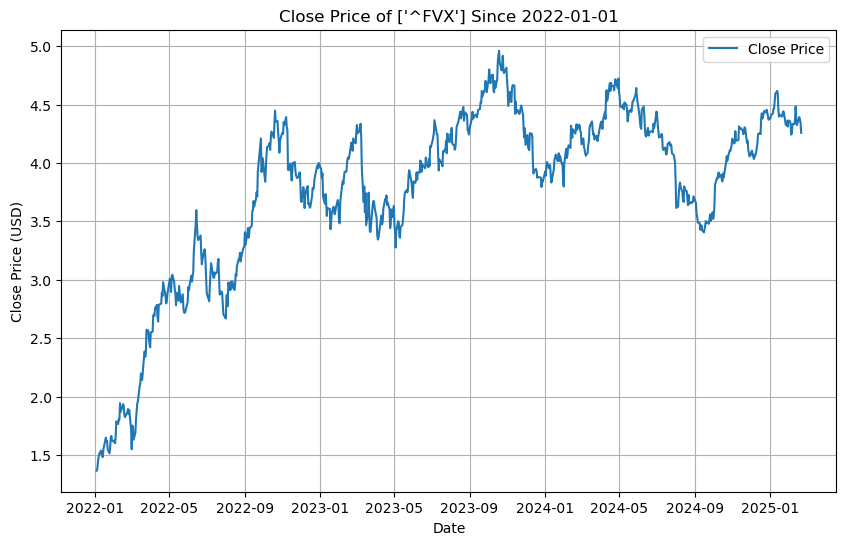

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(rfdata, label='Close Price')
plt.title(f'Close Price of {rfticker} Since {startDate}')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

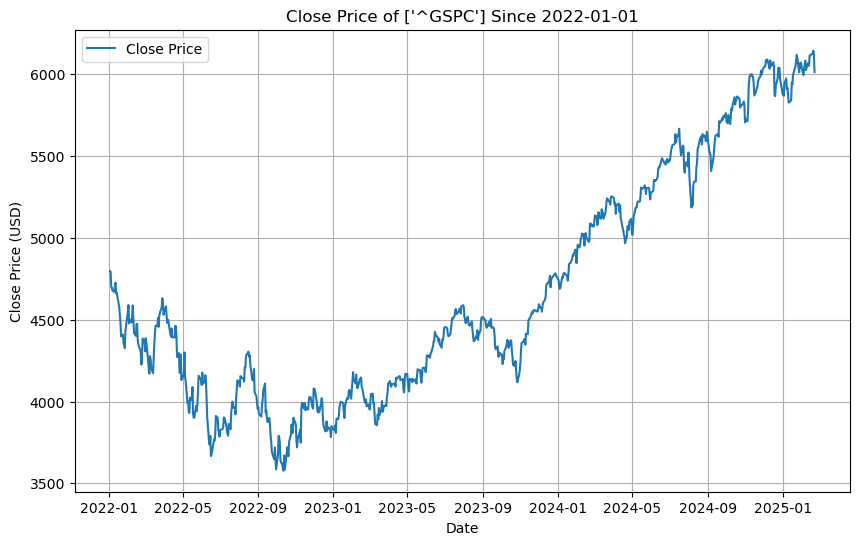

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(rmdata, label='Close Price')
plt.title(f'Close Price of {rmticker} Since {startDate}')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
# 4. Total Revenue Growth Y/Y
Y1R = fundamental.iloc[38, 1]
Y2R = fundamental.iloc[38, 2]
Rchange = Y2R/Y1R-1
Rchange = round(Rchange,2)

if 0.071 <= Rchange <= 999999999999999999999999:
    Rrating = 5
elif 0.041 <= Rchange <= 0.07:
    Rrating = 4
elif 0.021 <= Rchange <= 0.04:
    Rrating = 3
elif 0 <= Rchange <= 0.02:
    Rrating = 2
else:
    Rrating = 1
Rrating
Rscore = Rrating
Rscore
#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)


3

In [120]:
# 5. Total Net Income Growth Y/Y
NI1R = fundamental.iloc[22, 1]
NI2R = fundamental.iloc[22, 2]
NIchange = NI2R/NI1R-1
NIchange = round(NIchange,2)

if 0.071 <= NIchange <= 999999999999999999999999:
    NIrating = 5
elif 0.041 <= NIchange <= 0.07:
    NIrating = 4
elif 0.021 <= NIchange <= 0.04:
    NIrating = 3
elif 0 <= NIchange <= 0.02:
    NIrating = 2
else:
    NIrating = 1
NIrating
NIscore = NIrating
NIscore
#Strong Buy - (5)
#Buy - (4)
#Neutral - (3)
#Sell - (2)
#Strong Sell - (1)

3

In [121]:
#Fundamental Score Calculation
fundamental_score = 0.2*NIscore+0.2*Rscore+0.2*CAPMscore+0.2*PErating+0.2*EPSrating
fundamental_score

4.0

In [122]:
#Final Rating Calculation
#Technical Analysis Weight - 10%
#Monte Carlo Weight - 15%
#ARIMA Weight - 15%
#Fundamental Analysis Weight - 60%
final_score = 0.6*fundamental_score+0.15*ARIMArating+0.15*MCscore+0.1*techscore
final_score = round(final_score,1)
final_score1 = round(final_score,0)

if final_score1 == 5:
    finalrating = 'Strong Buy'
elif final_score1 == 4:
    finalrating = 'Buy'
elif final_score1 == 3:
    finalrating = 'Neutral'
elif final_score1 == 2:
    finalrating = 'Sell'
else:
    finalrating = 'Strong Sell'

print(f'The rating of {ticker} is {final_score} ({finalrating}) according to my stock scoring system. This is not an investment advice / не является инвестиционной рекомендацией.')

The rating of AAPL is 4.1 (Buy) according to my stock scoring system. This is not an investment advice / не является инвестиционной рекомендацией.
